## Code for competition

This is a 6 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D
from keras.layers import MaxPool2D, Flatten, Dropout, ZeroPadding2D, BatchNormalization
from keras.utils import np_utils
from keras.models import save_model, load_model
from keras.models import Model
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical 

Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("../Datasets/train.csv")
test = pd.read_csv("../Datasets/test.csv")
y_train = train["label"]
x_train = train.drop(labels = ["label"], axis = 1) 

I loaded more date from mnist in keras.datasets, can then combined them with the origin data provided. Because more training data means higher accuracy.

In [3]:
# Load the data from mnist
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)
x_train1 = train1.reshape(-1, 28*28)

I perform a grayscale normalization to reduce the effect of illumination's differences.<br>
Moreover the CNN converg faster on [0..1] data than on [0..255].

In [4]:
# Normalize the data
x_train = x_train / 255.0
x_train1 = x_train1 / 255.0
test = test / 255.0

In [5]:
# Combine all data
x_train = np.concatenate((x_train, x_train1))
y_train = np.concatenate((y_train, y_train1))

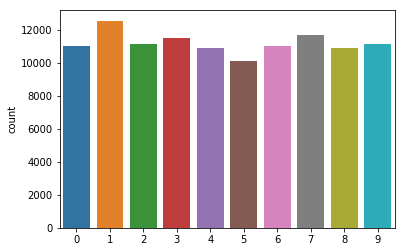

In [6]:
g = sns.countplot(y_train)

We have similar counts for the 10 digits.

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.reshape(-1,28,28,1).astype('float32')
test = test.values.reshape(-1,28,28,1)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = np_utils.to_categorical(y_train,10).astype('float32')

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [9]:
# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=2)

In [10]:
# Set attributions
batch_size = 124
n_filter = 32
pool_size = (2,2)

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

This is a 6 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset, includes the convolutional (Conv2D) layer, the pooling (MaxPool2D) layer, the ZeroPadding2D layer, the Flatten layer and two fully-connected (Dense) layers.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

In [11]:
# Set the CNN model 
cnn_net = Sequential()

cnn_net.add(Conv2D(32, kernel_size = (3,3), strides = (1,1),input_shape = (28,28,1)))
cnn_net.add(Activation('relu'))
cnn_net.add(BatchNormalization(epsilon = 1e-6, axis = 1))
cnn_net.add(MaxPool2D(pool_size = pool_size))

cnn_net.add(ZeroPadding2D((1,1)))
cnn_net.add(Conv2D(48, kernel_size = (3,3)))
cnn_net.add(Activation('relu'))
cnn_net.add(BatchNormalization(epsilon = 1e-6, axis = 1))
cnn_net.add(MaxPool2D(pool_size = pool_size))

cnn_net.add(ZeroPadding2D((1,1)))
cnn_net.add(Conv2D(64, kernel_size = (2,2)))
cnn_net.add(Activation('relu'))
cnn_net.add(BatchNormalization(epsilon = 1e-6, axis = 1))
cnn_net.add(MaxPool2D(pool_size = pool_size))

cnn_net.add(Dropout(0.25))
cnn_net.add(Flatten())

cnn_net.add(Dense(256))
cnn_net.add(Activation('relu'))

cnn_net.add(Dense(10))
cnn_net.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# Get dateils of model
cnn_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 48)        13872     
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 48)        0         
__________

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

In [13]:
# Compile the model
cnn_net.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Once our model is ready, we fit the training dataset .

In [14]:
# Fit the model
print('Start Training')
cnn_net = load_model('../Models/cnn_net_model.h5')
history = cnn_net.fit(x_train, y_train, batch_size=batch_size,
    epochs=5,
    verbose = 2,
    shuffle=True,
    validation_data=(x_val, y_val),
)
print('Training Completely!')

Start Training
Instructions for updating:
Use tf.cast instead.
Train on 100800 samples, validate on 11200 samples
Epoch 1/5
 - 256s - loss: 4.1594e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 0.9997
Epoch 2/5
 - 262s - loss: 7.2356e-05 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 0.9997
Epoch 3/5
 - 248s - loss: 1.4107e-04 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 0.9997
Epoch 4/5
 - 256s - loss: 3.0848e-05 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 0.9996
Epoch 5/5
 - 251s - loss: 7.1178e-05 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9996
Training Completely!


The result model after each times training will be saved to the path, it will be conveniently if you want to load a result model or if you want to continue your last training.

In [15]:
# Save the model
cnn_net.save('../Models/cnn_net_model.h5')

In [16]:
# Output the result.csv
y_pred = cnn_net.predict_classes(test,batch_size=32,verbose=1)
np.savetxt('../Datasets/result.csv',np.c_[range(1,len(y_pred)+1),y_pred],delimiter=',',header='ImageId,Label',comments='',fmt='%d')

28000/28000 [==============================] - 5s 171us/step


## Differences from public kernel

### Loaded more data: 
    At In[3] to In[5], I loaded more date from mnist in keras.datasets, can then combined them with the origin data provided. Because more training data means higher accuracy. And on the other hand, handle origin data and make some changes, then combined the changed data with the origin data also can have the same effect.

### Add attribution "shuffle" in fit:
    At In[14], I added shuffle attribution, it means whether to shuffle the training data before each epoch. It will improve the randomness of data and make the traing result more precise.

### Save model after training:
    At In[15], I added model.save(/path), the result model after each times training will be saved to the path, it will be conveniently if you want to load a result model or if you want to continue your last training.